## AutoGIS Final Assignment, Hanna Hirvonen

# AccessViz

AccessViz is a GIS-tool that visualizes and compares travel times by different travel modes in Helsinki Region.

The Helsinki Region Travel Time Matrix Data can be downloaded from http://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix/

### FileFinder

In [1]:
# Importing the necessary modules:
import geopandas as gpd
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import folium
import requests
import geojson

# Creating an empty list for the YKR IDs and the filepaths:
ykr_ids = []
user_fps = []

In [2]:
# The user creates a list of YKR IDs:
print('Enter the YKR ids one by one. Enter "0" when ready.')
while True:
    ele = int(input())
    if ele == 0:
        break
    else:
        ykr_ids.append(ele)

Enter the YKR ids one by one. Enter "0" when ready.


 5785640
 5785641
 5785642
 5785643
 0


In [3]:
# The user defines the input folder:
input_fp = str(input('Enter the filepath to the input folder:'))

Enter the filepath to the input folder: data/


In [4]:
# Searching for corresponding .txt files from the input folder:
num = 1
for i in ykr_ids:
    file = input_fp + 'travel_times_to_ ' + str(i) + '.txt'
    if num != len(ykr_ids):
        print('Process: ', num, '/', len(ykr_ids), ' -  Processing the file:', file)
    else:
        print('Process: ', num, '/', len(ykr_ids), ' -  Processing the file:', file)
        print('All done.')
    globfile = str(glob.glob(file))
    s = slice(2, -2)
    user_fps.append(globfile[s])
    num = num + 1

Process:  1 / 4  -  Processing the file: data/travel_times_to_ 5785640.txt
Process:  2 / 4  -  Processing the file: data/travel_times_to_ 5785641.txt
Process:  3 / 4  -  Processing the file: data/travel_times_to_ 5785642.txt
Process:  4 / 4  -  Processing the file: data/travel_times_to_ 5785643.txt
All done.


TableJoiner

In [5]:
# Reading the grid-shapefile into a new GeoDataFrame:
grid_fp = 'data/grid/MetropAccess_YKR_grid_EurefFIN.shp'
grid = gpd.read_file(grid_fp)

# The user defines the output folder:
output_fp = str(input('Enter the filepath to the output folder:'))

# Reading the YKR cells from the filepaths into new dataframes and joining them with the grid:
merged_fps = []
for i in user_fps:
    fp = i
    df = pd.read_csv(fp, sep=';')
    sl = slice(21, -4)
    file_name = fp[sl] + '.shp'
    merged_grid = grid.merge(df, left_on='YKR_ID', right_on='from_id')
    merged_grid.replace(to_replace=-1, value=np.nan, inplace=True)
    merged_grid.dropna(inplace=True)
    output = os.path.join(output_fp, file_name)
    merged_grid.to_file(output)
    merged_fps.append(file_name)

Enter the filepath to the output folder: data/output/


Visualizer

In [6]:
# The user determines which traveling modes are visualized:
print('Enter which traveling modes are visualized (car, public transport, walking, biking). Type "stop" when finished:')
modes = []
while True:
    ele = str(input())
    if ele == 'stop':
        break
    else:
        modes.append(ele)

Enter which traveling modes are visualized (car, public transport, walking, biking). Type "stop" when finished:


 car
 stop


In [23]:
# The user determines whether the map is static or interactive:
s_or_ia = input('Enter "static" for a static map or "interactive" for an interactive map:')

Enter "static" for a static map or "interactive" for an interactive map: static


In [8]:
# The user determines the output folder for the maps:
output_vis = input('Enter the output filepath for the visualization:')

Enter the output filepath for the visualization: data/output/


In [25]:
# Visualizing the travel times:
s_title = slice(0, -4)
def get_column(mode):
    if mode == 'car':
        col = 'car_r_t'
    elif mode == 'public transport':
        col = 'pt_r_t'
    elif mode == 'walking':
        col = 'walk_t'
    elif mode == 'biking':
        col = 'bike_f_t'
    return col

def static_map(col, file, mode, file_name):
    fig, ax = plt.subplots(figsize=(12,8))
    file.plot(ax=ax, 
          column=col, 
          linewidth=0.03, 
          cmap="Spectral", 
          scheme="quantiles", 
          k=9, 
          legend=True, 
          )
    ax.get_legend().set_bbox_to_anchor((1.3,1))
    ax.set_title(file_name[s_title])
    legend_title = 'Travel time in minutes ' + 'by ' + mode
    ax.get_legend().set_title(legend_title)
    plt.tight_layout()
    out_fp = output_vis + file_name[s_title] + '_' + i + '.png'
    plt.savefig(out_fp, dpi=300)
    return None

def interactive_map(col, file, mode, file_name):
    file['geoid'] = file.index.astype(str)
    mode_col = get_column(mode)
    file = file[['geoid', mode_col, 'geometry']]
    title = 'Travel time ' + 'by ' + mode
    legend_title = 'Travel time in minutes ' + 'by ' + mode
    m = folium.Map(location=[60.25, 24.8], 
                   tiles = 'cartodbpositron', 
                   zoom_start=10, 
                   control_scale=True)
    folium.Choropleth(
    geo_data=file,
    name=title,
    data=file,
    columns=['geoid', mode_col],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_color='white', 
    line_weight=0,
    highlight=False, 
    smooth_factor=1.0,
    legend_name=legend_title).add_to(m)
    out_fp = output_vis + file_name[s_title] + '_' + i + '.html'
    m.save(out_fp)
    return None

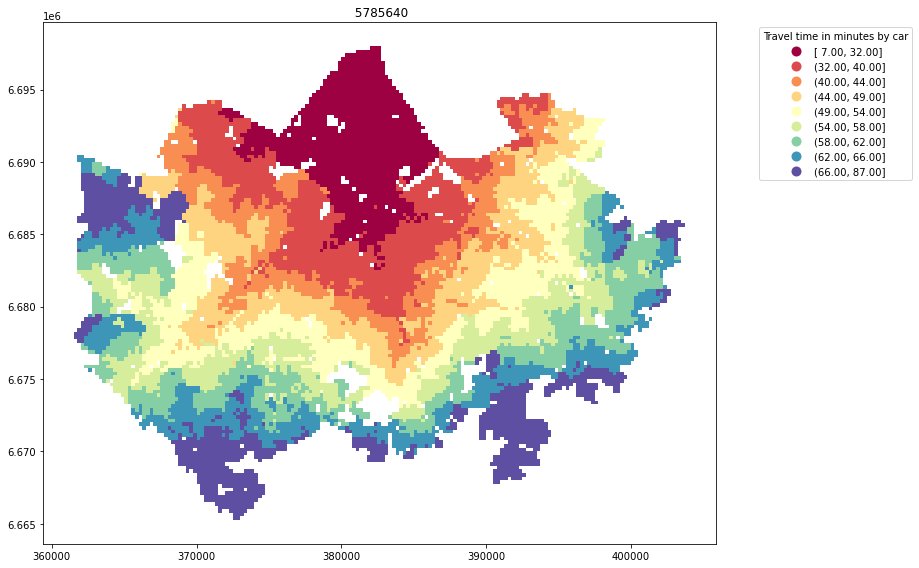

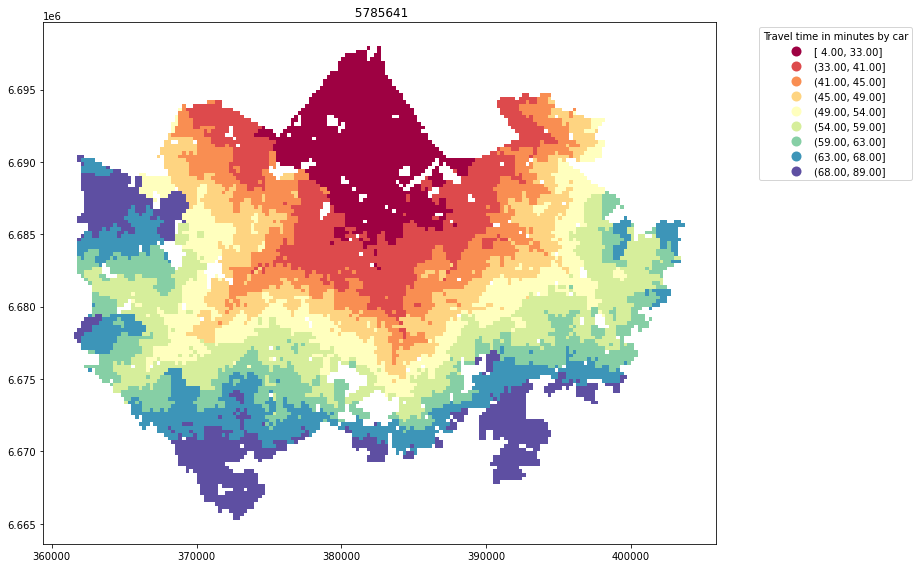

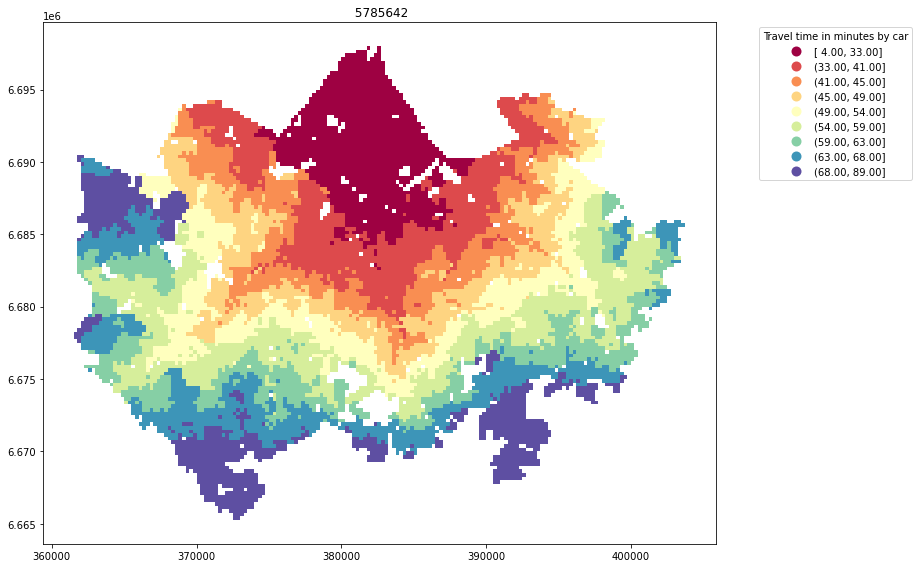

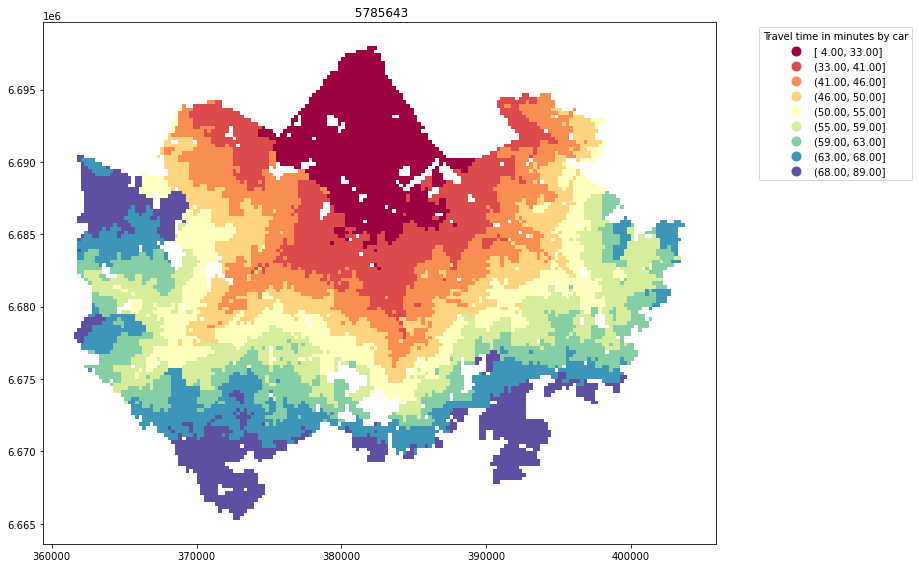

In [26]:
def visualize(mode, file, file_name):
    col = get_column(mode)
    if s_or_ia == 'static':
        static_map(col, file, mode, file_name)
    elif s_or_ia == 'interactive':
        interactive_map(col, file, mode, file_name)
    return None

for i in modes:
    for file_name in merged_fps:
        filepath = output_fp + file_name
        merged = gpd.read_file(filepath)
        figure = visualize(i, merged, file_name)

Comparison tool